In [16]:
%load_ext autoreload
%autoreload 2
import site, pathlib, subprocess, sys
sys.path.insert(0,"/home/mt622/GitHubRepos/FractionalBrownianMotion")
repo_root = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], text=True
).strip()
pth_dir = pathlib.Path(site.getsitepackages()[0])
(pth_dir / "namerepo_root.pth").write_text(repo_root + "\n")
print("Wrote", pth_dir / "namerepo_root.pth")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Wrote /Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages/namerepo_root.pth


In [17]:
import pickle
from configs import project_config
import numpy as np
import torch
import os
from tqdm import tqdm
from src.classes.ClassConditionalStbleTgtMarkovianPostMeanDiffTrainer import \
    ConditionalStbleTgtMarkovianPostMeanDiffTrainer
from src.generative_modelling.data_processing import train_and_save_recursive_diffusion_model
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
from utils.data_processing import init_experiment, cleanup_experiment
from utils.math_functions import generate_fQuadSin
from utils.resource_logger import ResourceLogger

In [18]:
# Data parameters
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config
config = get_config()

In [19]:
assert (config.hurst == 0.5)
assert (config.early_stop_idx == 0)
assert (config.tdata_mult == 110)
#assert (config.sin_space_scale == 25.)
assert (config.feat_thresh == 1./500.)
print(config.scoreNet_trained_path, config.dataSize)
rng = np.random.default_rng()
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)


/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtNFMReg_fQuadSinHF_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_MLP_H4_CUp20_tl110 40000


In [20]:
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and ("EE" in file and "Trk" not in file) and "fQuad" in file:
        good = ConditionalMarkovianTSPostMeanScoreMatching(
    *config.model_parameters)
        print(file)
        entered = True
        good.load_state_dict(torch.load(os.path.join(model_dir, file)))
assert entered

trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtNFMReg_fQuadSinHF_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_MLP_H4_CUp20_tl110_EENEp485


In [85]:
#Xshape = 256
#Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
Xs = np.load("/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fQuadSinHF_samples_t00_dT3906e-03_T256_05a_004b_250c_10Diff_00Init.npy")[:int(4*257),-1].T.flatten()
Xshape = Xs.shape[0]
true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(config.sin_space_scale * Xs))
true_drifts = true_drifts[:, np.newaxis]#.numpy()

In [86]:
remote_file_path = project_config.ROOT_DIR+"data/" #/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/"
remote_file_path

'/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/'

In [87]:
from utils.drift_evaluation_functions import experiment_MLP_DDims_drifts, multivar_score_based_MLP_drift_OOS
es=0
DNonGauss = experiment_MLP_DDims_drifts(config=config, Xs=Xs, good=good, onlyGauss=False)
DNonGauss = DNonGauss[:, -1, :, :].reshape((DNonGauss.shape[0],DNonGauss.shape[2],DNonGauss.shape[
                                                                                           -1] * 1), order="C").mean(axis=1)

In [88]:
DGauss = multivar_score_based_MLP_drift_OOS(score_model=good, num_diff_times=1, diffusion=diffusion, num_paths=Xs.shape[0], prev=Xs[:, np.newaxis],ts_step=config.deltaT, config=config,device="cpu")[:, 0, :]

In [89]:
print(np.mean(np.power(DNonGauss-true_drifts, 2), axis=(0,1)))
print(np.mean(np.power(DGauss-true_drifts, 2), axis=(0,1)))

0.007774637889989043
0.007774639354894619


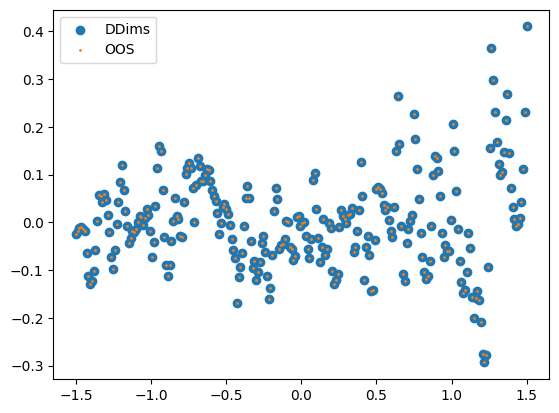

In [59]:
import matplotlib.pyplot as plt
plt.scatter(Xs.flatten(),(DNonGauss-true_drifts).flatten(), label="DDims" )
plt.scatter(Xs.flatten(),(DGauss-true_drifts).flatten(), s=1,label="OOS" )
plt.legend()
plt.show()

In [15]:
def compute_MSE_CIs(muhats):
    estimates = np.mean(muhats, axis=2)
    errors = estimates - true_drifts[:, np.newaxis,:]
    deltas = (muhats) - estimates[:,:, np.newaxis,:]
    #norms = np.sqrt(np.sum(np.power(errors,2), axis=-1, keepdims=True))
    us = errors#/norms
    us = 2*us.transpose((1,0,2))
    deltas = deltas.transpose((1,0,2,3))
    val=np.mean(np.sum(us[:, :, np.newaxis, :]*deltas,axis=-1) ,axis=1)
    std = np.std(val, axis=-1)
    mse = np.mean((np.sum(np.power(errors,2), axis=-1)), axis=0)
    return mse, std

In [9]:
DNonGauss=np.load(remote_file_path + "QuadSinHF_optimal_tau_experiment_DNonGauss.npy", allow_pickle=True)
DGauss=np.load(remote_file_path + "QuadSinHF_optimal_tau_experiment_DGauss.npy", allow_pickle=True)
NonGauss_mse, NonGauss_std = compute_MSE_CIs(muhats=DNonGauss)
Gauss_mse, Gauss_std = compute_MSE_CIs(muhats=DGauss)


[0.001      0.00109991 0.00119982 ... 0.99980018 0.99990009 1.        ]


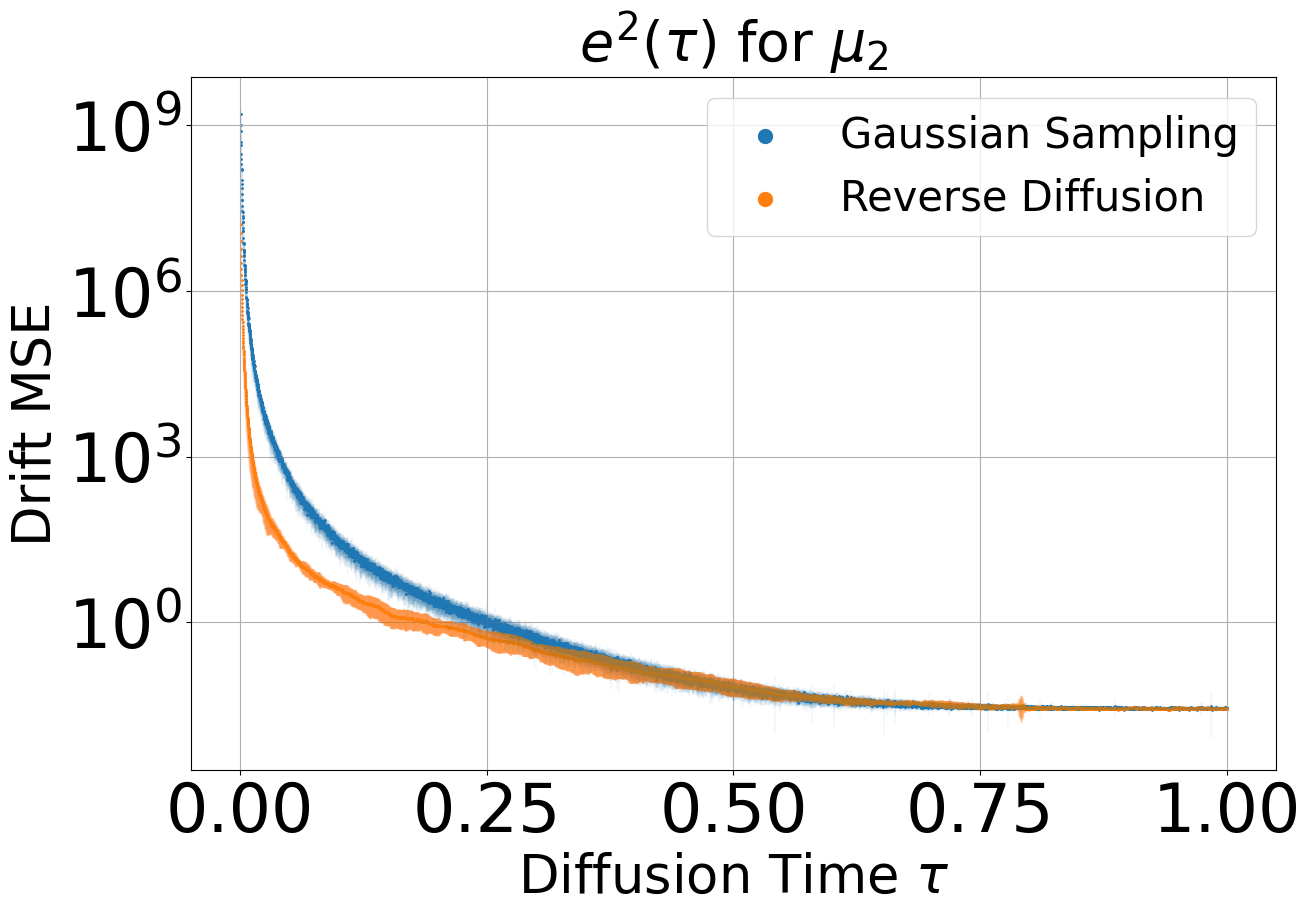

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,9))
startidx=0
diff_times = np.linspace(config.train_eps, 1, config.max_diff_steps)
print(diff_times)
plt.scatter(diff_times[startidx:],Gauss_mse[startidx:],s=1, label="Gaussian Sampling")
plt.errorbar(x=diff_times[startidx:],y=Gauss_mse[startidx:], yerr=Gauss_std[startidx:], alpha=0.05)
plt.scatter(diff_times[startidx:],NonGauss_mse[startidx:],s=1, label="Reverse Diffusion")
plt.errorbar(x=diff_times[startidx:],y=NonGauss_mse[startidx:], yerr=NonGauss_std[startidx:], alpha=0.05)
plt.yscale("log")
plt.title(r"$e^{2}(\tau)$ for $\mu_2$", fontsize=40)
plt.xlabel(rf"Diffusion Time $\tau$", fontsize=38)
plt.ylabel("Drift MSE",fontsize=38)
ax.tick_params(labelsize=48)
plt.grid(True)
plt.legend(markerscale=10,fontsize=30)
plt.show()
plt.close()

[0.001      0.00109991 0.00119982 ... 0.99980018 0.99990009 1.        ]


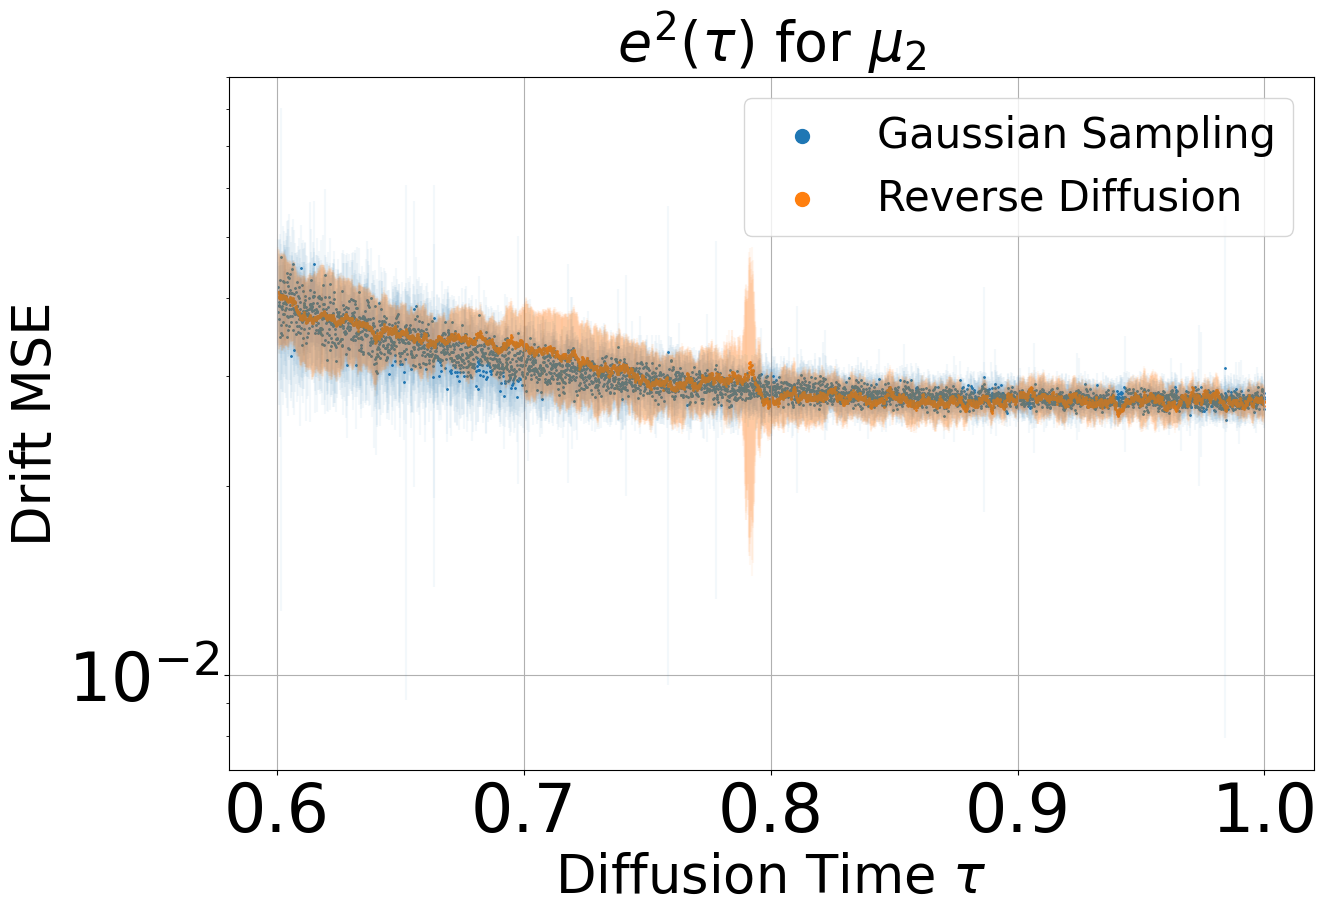

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,9))
startidx=6000
diff_times = np.linspace(config.train_eps, 1, config.max_diff_steps)
print(diff_times)
plt.scatter(diff_times[startidx:],Gauss_mse[startidx:],s=1, label="Gaussian Sampling")
plt.errorbar(x=diff_times[startidx:],y=Gauss_mse[startidx:], yerr=Gauss_std[startidx:], alpha=0.05)
plt.scatter(diff_times[startidx:],NonGauss_mse[startidx:],s=1, label="Reverse Diffusion")
plt.errorbar(x=diff_times[startidx:],y=NonGauss_mse[startidx:], yerr=NonGauss_std[startidx:], alpha=0.05)
plt.yscale("log")
plt.title(r"$e^{2}(\tau)$ for $\mu_2$", fontsize=40)
plt.xlabel(rf"Diffusion Time $\tau$", fontsize=38)
plt.ylabel("Drift MSE",fontsize=38)
ax.tick_params(labelsize=48)
plt.grid(True)
plt.legend(markerscale=10,fontsize=30)
ax.tick_params(axis="y",which="minor", labelsize=38)
plt.show()
plt.close()

0.027286570255115307


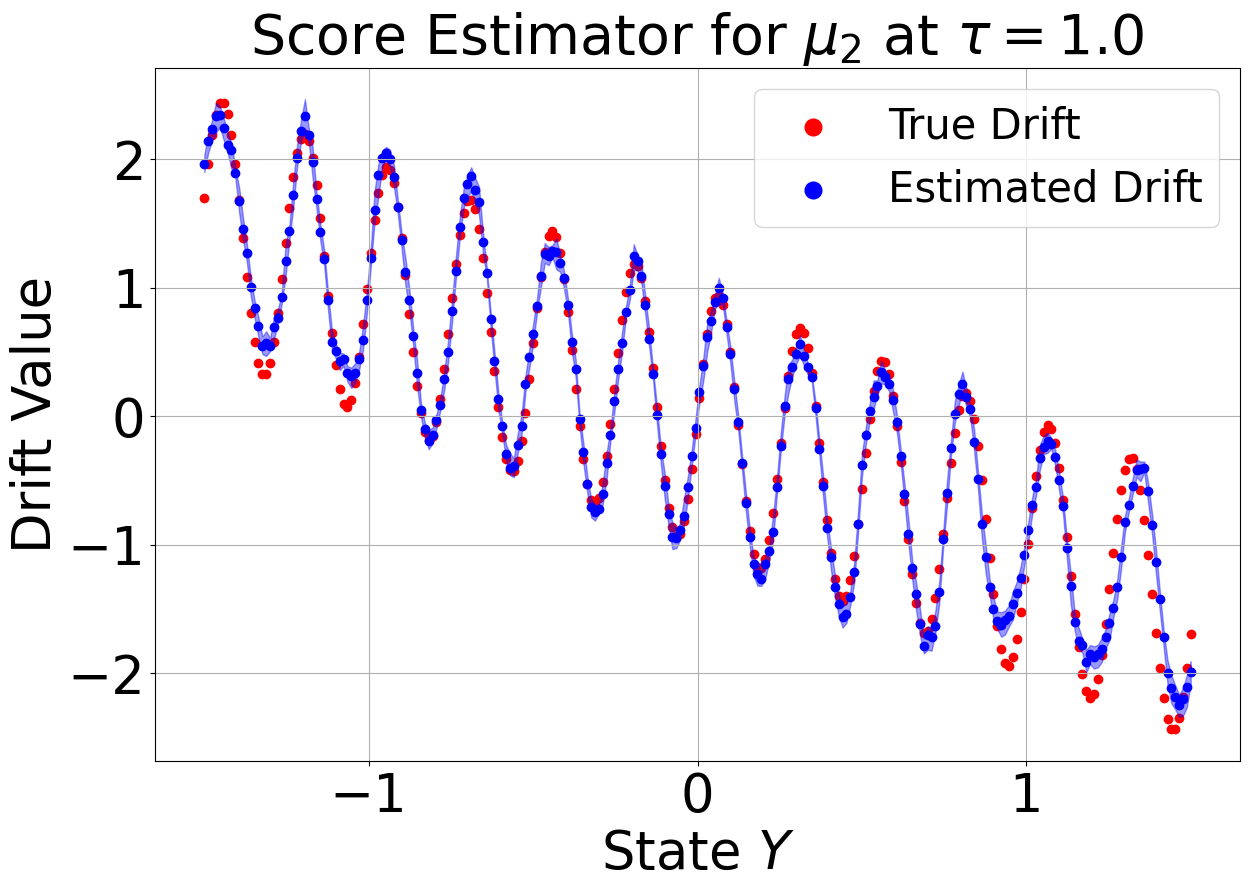

In [12]:
fig, ax = plt.subplots(figsize=(14,9))
tauidx = 9999
tau_NonGauss = DNonGauss[:, tauidx, :, :]
estimate = np.mean(tau_NonGauss, axis=1)
for d in range(tau_NonGauss.shape[-1]):
    plt.scatter(Xs, true_drifts[:, d], color="red", label="True Drift")
    plt.scatter(Xs, estimate[:, d], label="Estimated Drift",color="blue")
    lowq_tau_errors = np.quantile(tau_NonGauss[:,:, d], q=0.1, axis=-1)
    highq_tau_errors = np.quantile(tau_NonGauss[:,:,d], q=0.9, axis=-1)
    plt.fill_between(Xs,lowq_tau_errors, highq_tau_errors, alpha=0.4,color="blue")
    print((np.mean(np.sum(np.power(estimate-true_drifts,2), axis=-1))))
plt.title(rf"Score Estimator for $\mu_2$ at $\tau=${round(diff_times[tauidx],3)}", fontsize=40)
plt.grid(True)
plt.legend(fontsize=30, markerscale=2)
ax.tick_params(labelsize=38)
plt.ylabel("Drift Value", fontsize=38)
plt.xlabel(rf"State $Y$", fontsize=38)
plt.show()
plt.close()

4.037756582789278


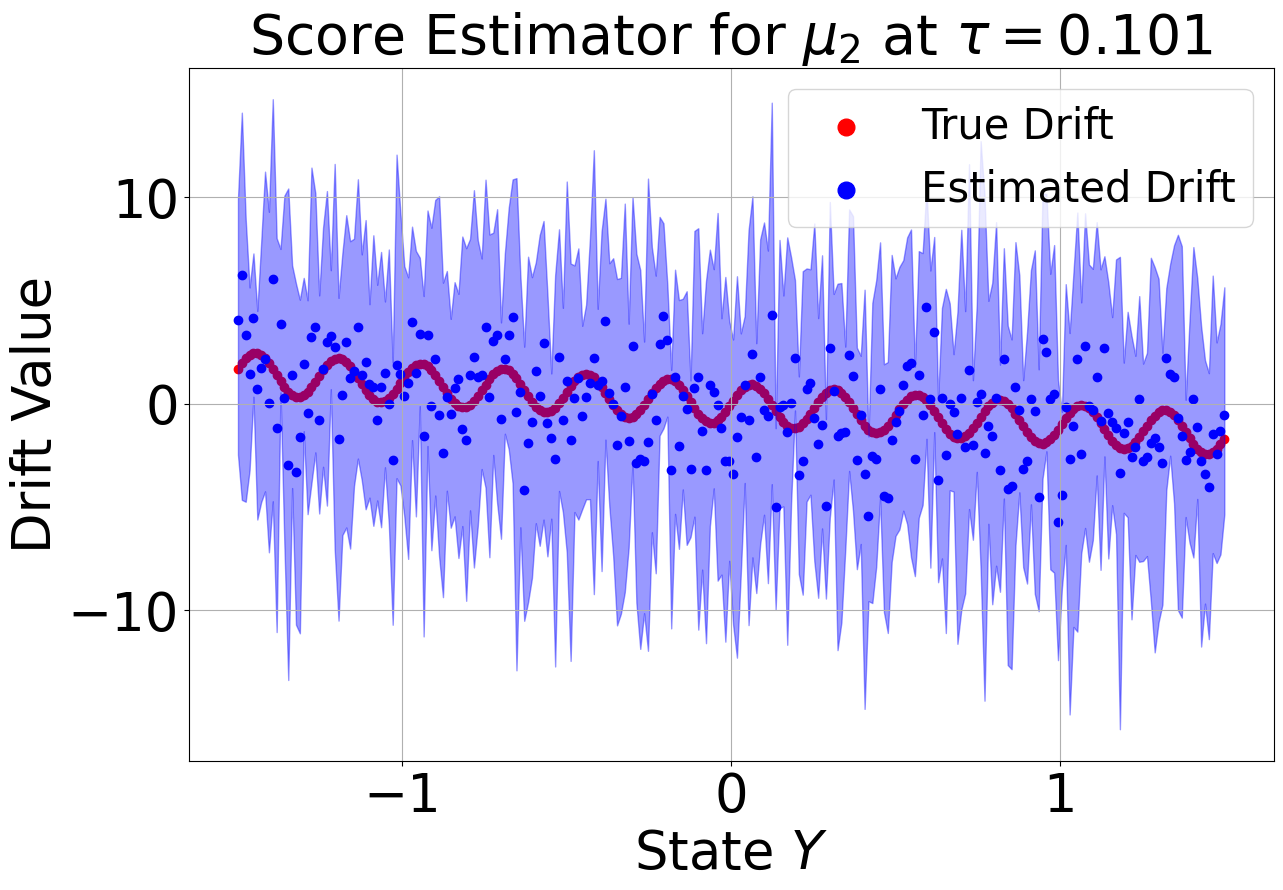

In [13]:
fig, ax = plt.subplots(figsize=(14,9))
tauidx = 1000
tau_NonGauss = DNonGauss[:, tauidx, :, :]
estimate = np.mean(tau_NonGauss, axis=1)
for d in range(tau_NonGauss.shape[-1]):
    plt.scatter(Xs, true_drifts[:, d], color="red", label="True Drift")
    plt.scatter(Xs, estimate[:, d], label="Estimated Drift",color="blue")
    lowq_tau_errors = np.quantile(tau_NonGauss[:,:, d], q=0.1, axis=-1)
    highq_tau_errors = np.quantile(tau_NonGauss[:,:,d], q=0.9, axis=-1)
    plt.fill_between(Xs,lowq_tau_errors, highq_tau_errors, alpha=0.4,color="blue")
    print((np.mean(np.sum(np.power(estimate-true_drifts,2), axis=-1))))
plt.title(rf"Score Estimator for $\mu_2$ at $\tau=${round(diff_times[tauidx],3)}", fontsize=40)
plt.grid(True)
plt.legend(fontsize=30, markerscale=2)
ax.tick_params(labelsize=38)
plt.ylabel("Drift Value", fontsize=38)
plt.xlabel(rf"State $Y$", fontsize=38)
plt.show()
plt.close()